In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Rice_Citation_Request.txt
/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (11154).jpg
/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (8058).jpg
/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5150).jpg
/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (8267).jpg
/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (8747).jpg
/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (2970).jpg
/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (10959).jpg
/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (4976).jpg
/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (730).jpg
/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (9279).jpg
/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (534).jpg
/kaggle/i

<div style="position: relative; text-align: center; color: white; height: 300px; overflow: hidden;"">
  <img src="https://images.unsplash.com/photo-1646980990815-1e97d5ee932f?q=80&w=2100&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D" alt="Background" style="width: 100%; opacity: 0.3;">
  <div style="position: absolute; top: 40%; left: 25%; transform: translate(-50%, -50%); text-align: center">
    <h1 style="font-weight: bold;">RiceDetection | CNN using TF & Keeas</h1>
  </div>
</div>

**Hi!**

In this project we use [Rice image Dataset](https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset) for rice categorization with **CNN** architecure using **TensorFlow & Keras** API.

Hope you enjoy and support this notebook!

# Importing Libs.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style('darkgrid')
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation,Dropout,BatchNormalization
from keras.models import Model, Sequential
from tensorflow.keras import callbacks
from keras.optimizers import Adam
from tensorflow.keras.optimizers import AdamW
from keras.metrics import categorical_crossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, Callback
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
import imageio
import matplotlib.image as img
import pathlib 
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.applications import imagenet_utils

In [4]:
if tf.config.list_physical_devices('GPU'):
    print("Using GPU")
else:
    print("Using CPU")

Using GPU


In [6]:
train_gen=ImageDataGenerator(rescale=1./255,validation_split=0.2)
train=train_gen.flow_from_directory('/kaggle/input/rice-image-dataset/Rice_Image_Dataset',
                                         target_size=(224,224),batch_size=32
                                         ,class_mode='categorical',shuffle=True,subset='training')

test = train_gen.flow_from_directory('/kaggle/input/rice-image-dataset/Rice_Image_Dataset',
                                        target_size=(224,224),batch_size=128,class_mode = 'categorical', shuffle = True, subset = None)

val=train_gen.flow_from_directory("/kaggle/input/rice-image-dataset/Rice_Image_Dataset",
                                        target_size=(224,224),batch_size=32
                                        ,shuffle=False,subset='validation')

Found 60000 images belonging to 5 classes.
Found 75000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


In [7]:
class TestCallback(Callback):
    def __init__(self,test_data):
        self.test_data = test_data
    def on_epoch_end(self,epoch,logs = None):
        test_loss , test_accuracy = self.model.evaluate(self.test_data, verbose = 0)
        print(f'\n Epoch{epoch+1}: Test loss = {test_loss},Test Accuracy = {test_accuracy}')

In [ ]:
print("Train class names: ", train.class_indices.keys())
print("Validation class names: ", val.class_indices.keys())

In [8]:
strategy = tf.distribute.MirroredStrategy()

In [8]:
with strategy.scope():
    # Create the model
    model1 = Sequential([
        # First Convolutional Block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.2),
    
        # Second Convolutional Block
        tf.keras.layers.Conv2D(64, (3, 3), activation='swish', kernel_regularizer = l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.2),
    
        # Third Convolutional Block
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.2),

        # Fourth Convolutional Block
        tf.keras.layers.Conv2D(256, (3, 3), activation='swish'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.2),
    
        # Flatten the output
        tf.keras.layers.Flatten(),
    
        # Fully Connected Layers
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    # Define the checkpoint, explicitly setting the format to "h5"
    checkpoint = ModelCheckpoint(
    "best_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max"
)


# Compile the model
    model1.compile(optimizer=Adam(learning_rate=0.001),
               loss='categorical_crossentropy',
               metrics=['accuracy'])
    


In [10]:
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     9,437,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,485,265 (112.48 MB)

 Trainable params: 9,828,101 (37.49 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 19,656,204 (74.98 MB)

In [ ]:
# Train the model
model1_history = model1.fit(
    train,
    epochs=15,
    validation_data=val,  
    callbacks = [checkpoint]

)

In [12]:
TL_model1 = model1_history.history['loss']
VL_model1 = model1_history.history['val_loss']
TA_model1 = model1_history.history['accuracy']
VA_model1 = model1_history.history['val_accuracy']

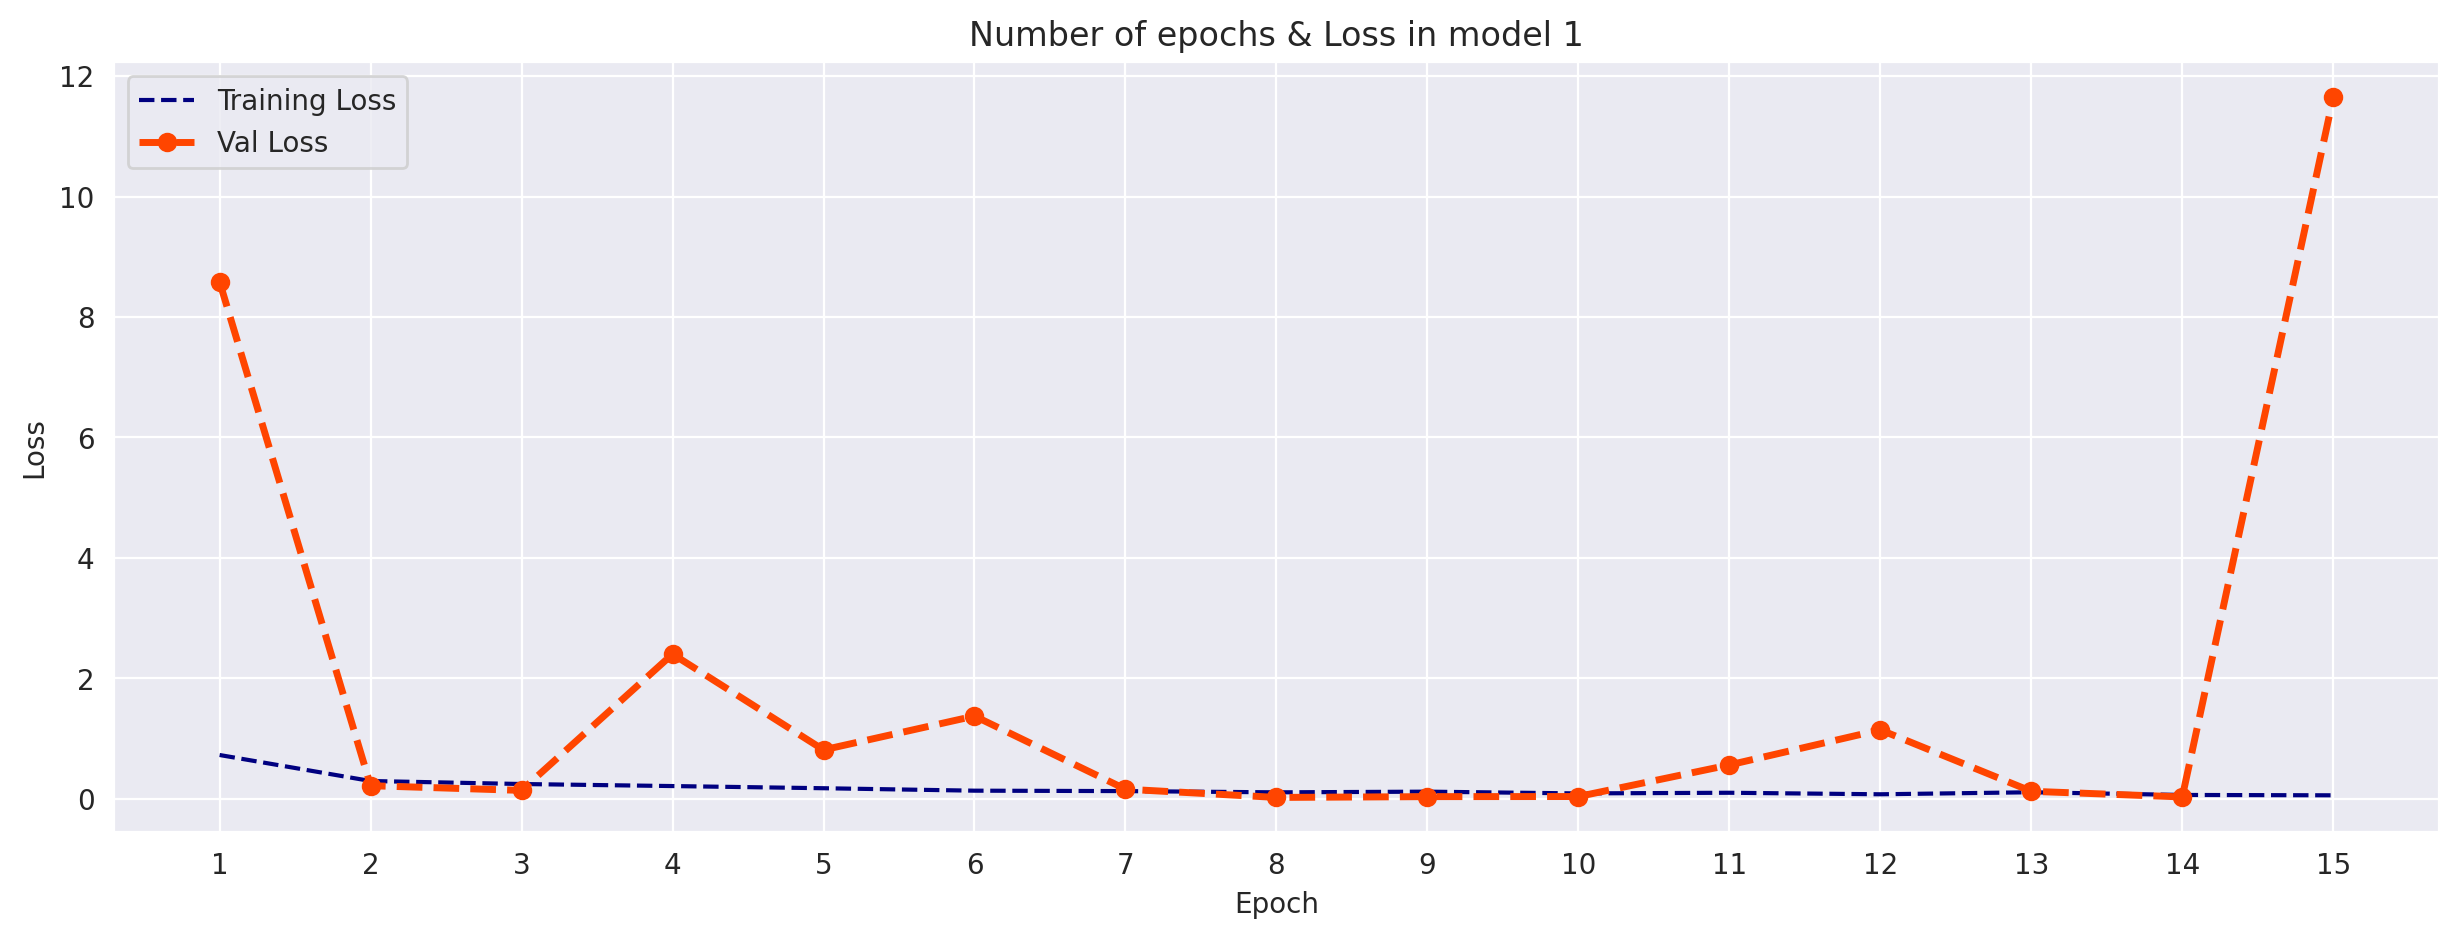

In [18]:
epoch_count = range(1, len(TL_model1) + 1)

# Visualize loss history
plt.figure(figsize=(15,5), dpi=200)
plt.plot(epoch_count, TL_model1, 'r--', color= 'navy')
plt.plot(epoch_count, VL_model1, '--bo',color= 'orangered', linewidth = '2.5', label='line with marker')
plt.legend(['Training Loss', 'Val Loss'])
plt.title('Number of epochs & Loss in model 1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(1,16,1))
plt.show();

**Initial Improvement**: The validation loss drops significantly in the first two epochs, indicating the model quickly learns basic patterns from the data.

**Stability of Training Loss**: The training loss remains low and stable throughout the epochs, suggesting the model fits the training data well.

**Validation Loss Fluctuations**: The validation loss shows high variability after epoch 3, with occasional spikes, indicating potential issues such as overfitting or sensitivity to data noise.

**Validation Loss Explosion**: At epoch 14, the validation loss dramatically increases, which could indicate overfitting, gradient instability, or a poorly tuned learning rate.

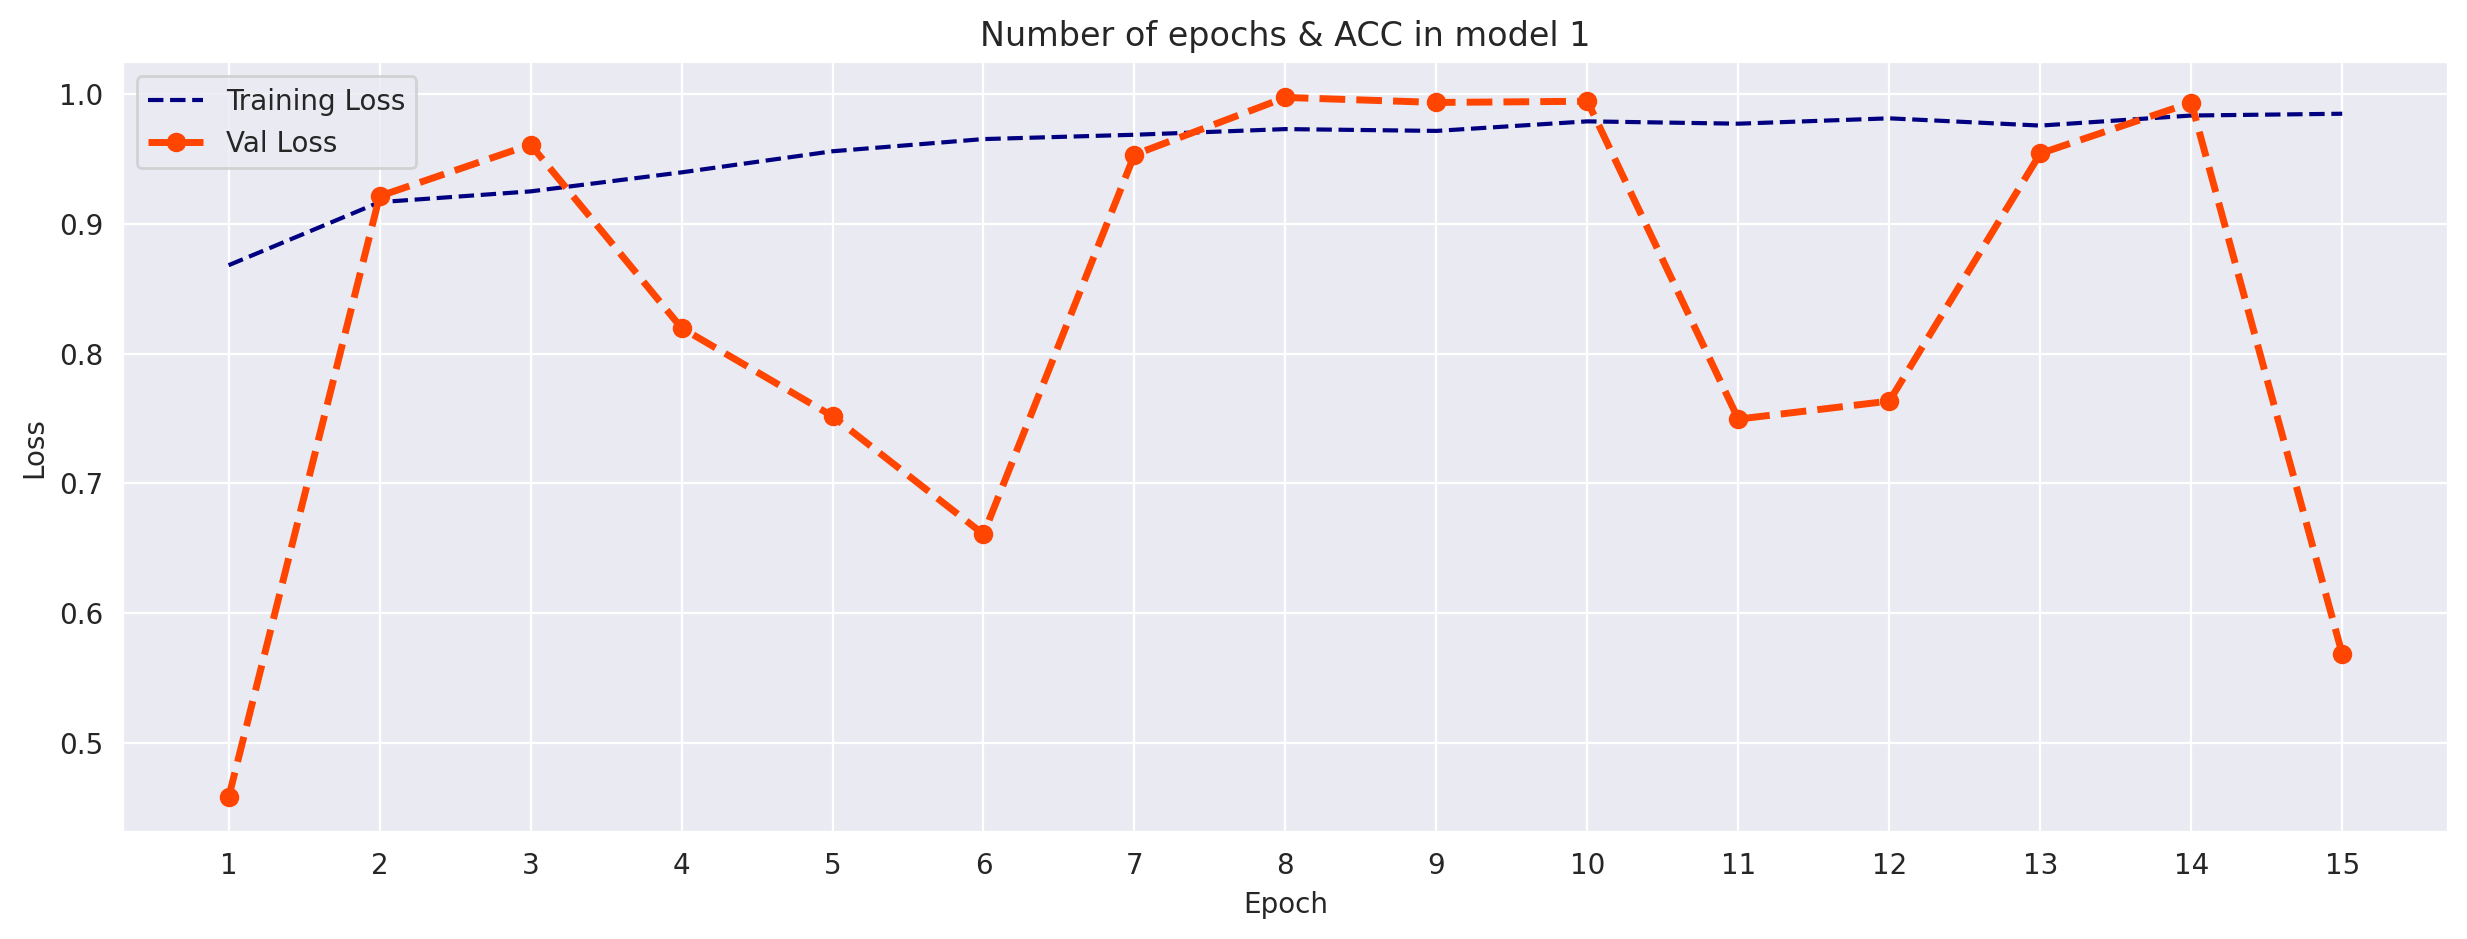

In [19]:
# Visualize Acc history
plt.figure(figsize=(15,5), dpi=200)
plt.plot(epoch_count, TA_model1, 'r--', color= 'navy')
plt.plot(epoch_count, VA_model1, '--bo',color= 'orangered', linewidth = '2.5', label='line with marker')
plt.legend(['Training Loss', 'Val Loss'])
plt.title('Number of epochs & ACC in model 1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(1,16,1))
plt.show();

**Training Loss Stability**: The training loss remains relatively stable throughout the epochs, showing that the model consistently fits the training data.

**Validation Loss Fluctuations**: The validation loss exhibits significant oscillations, suggesting the model struggles with generalization and may be sensitive to the validation data.

**Validation Loss Drop at Specific Epochs**: Around epochs 4-6 and 10-12, the validation loss decreases, indicating moments where the model temporarily achieves better performance on the validation set.

**Final Validation Loss Spike**: After epoch 14, there is a sharp increase in validation loss, potentially indicating overfitting, instability, or issues with the model architecture or optimization.

In [10]:
with strategy.scope():
    # Create the model
    model2 = Sequential([
        # First Convolutional Block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.2),
    
        # Second Convolutional Block
        tf.keras.layers.Conv2D(64, (3, 3), activation='swish', kernel_regularizer = l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    
        # Flatten the output
        tf.keras.layers.Flatten(),
    
        # Fully Connected Layers
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    # Define the checkpoint, explicitly setting the format to "h5"
    checkpoint = ModelCheckpoint(
    "best_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max"
)


# Compile the model
    model2.compile(optimizer=Adam(learning_rate=0.001),
               loss='categorical_crossentropy',
               metrics=['accuracy'])
    


In [11]:
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    47,776,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,797,061 (182.33 MB)

 Trainable params: 47,796,869 (182.33 MB)

 Non-trainable params: 192 (768.00 B)

In [12]:
# Train the model
model2_history = model2.fit(
    train,
    epochs=15,
    validation_data=val,  
    callbacks = [checkpoint]

)

Epoch 1/15


2024-11-21 14:38:48.532803: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/cond/else/_138/cond/StatefulPartitionedCall/replica_1/sequential_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 496s 258ms/step - accuracy: 0.8907 - loss: 5.2679 - val_accuracy: 0.9488 - val_loss: 0.6370
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 230s 122ms/step - accuracy: 0.9563 - loss: 0.6201 - val_accuracy: 0.9633 - val_loss: 0.3122
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 227s 121ms/step - accuracy: 0.9533 - loss: 0.6903 - val_accuracy: 0.8909 - val_loss: 0.4263
Epoch 4/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 230s 122ms/step - accuracy: 0.9626 - loss: 0.3457 - val_accuracy: 0.9691 - val_loss: 0.1987
Epoch 5/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 230s 122ms/step - accuracy: 0.9644 - loss: 0.2795 - val_accuracy: 0.9649 - val_loss: 0.2250
Epoch 6/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 230s 122ms/step - accuracy: 0.9685 - loss: 0.2223 - val_accuracy: 0.9785 - val_loss: 0.1713
Epoch 7/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 232s 123ms/step - accuracy: 0.9719 - loss: 0.1855 - val_accuracy: 0.9805 - val_loss: 0.1671
Epoch 8/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 233s 124ms/step - accuracy: 0.9

In [13]:
TL_model2 = model2_history.history['loss']
VL_model2 = model2_history.history['val_loss']
TA_model2 = model2_history.history['accuracy']
VA_model2 = model2_history.history['val_accuracy']

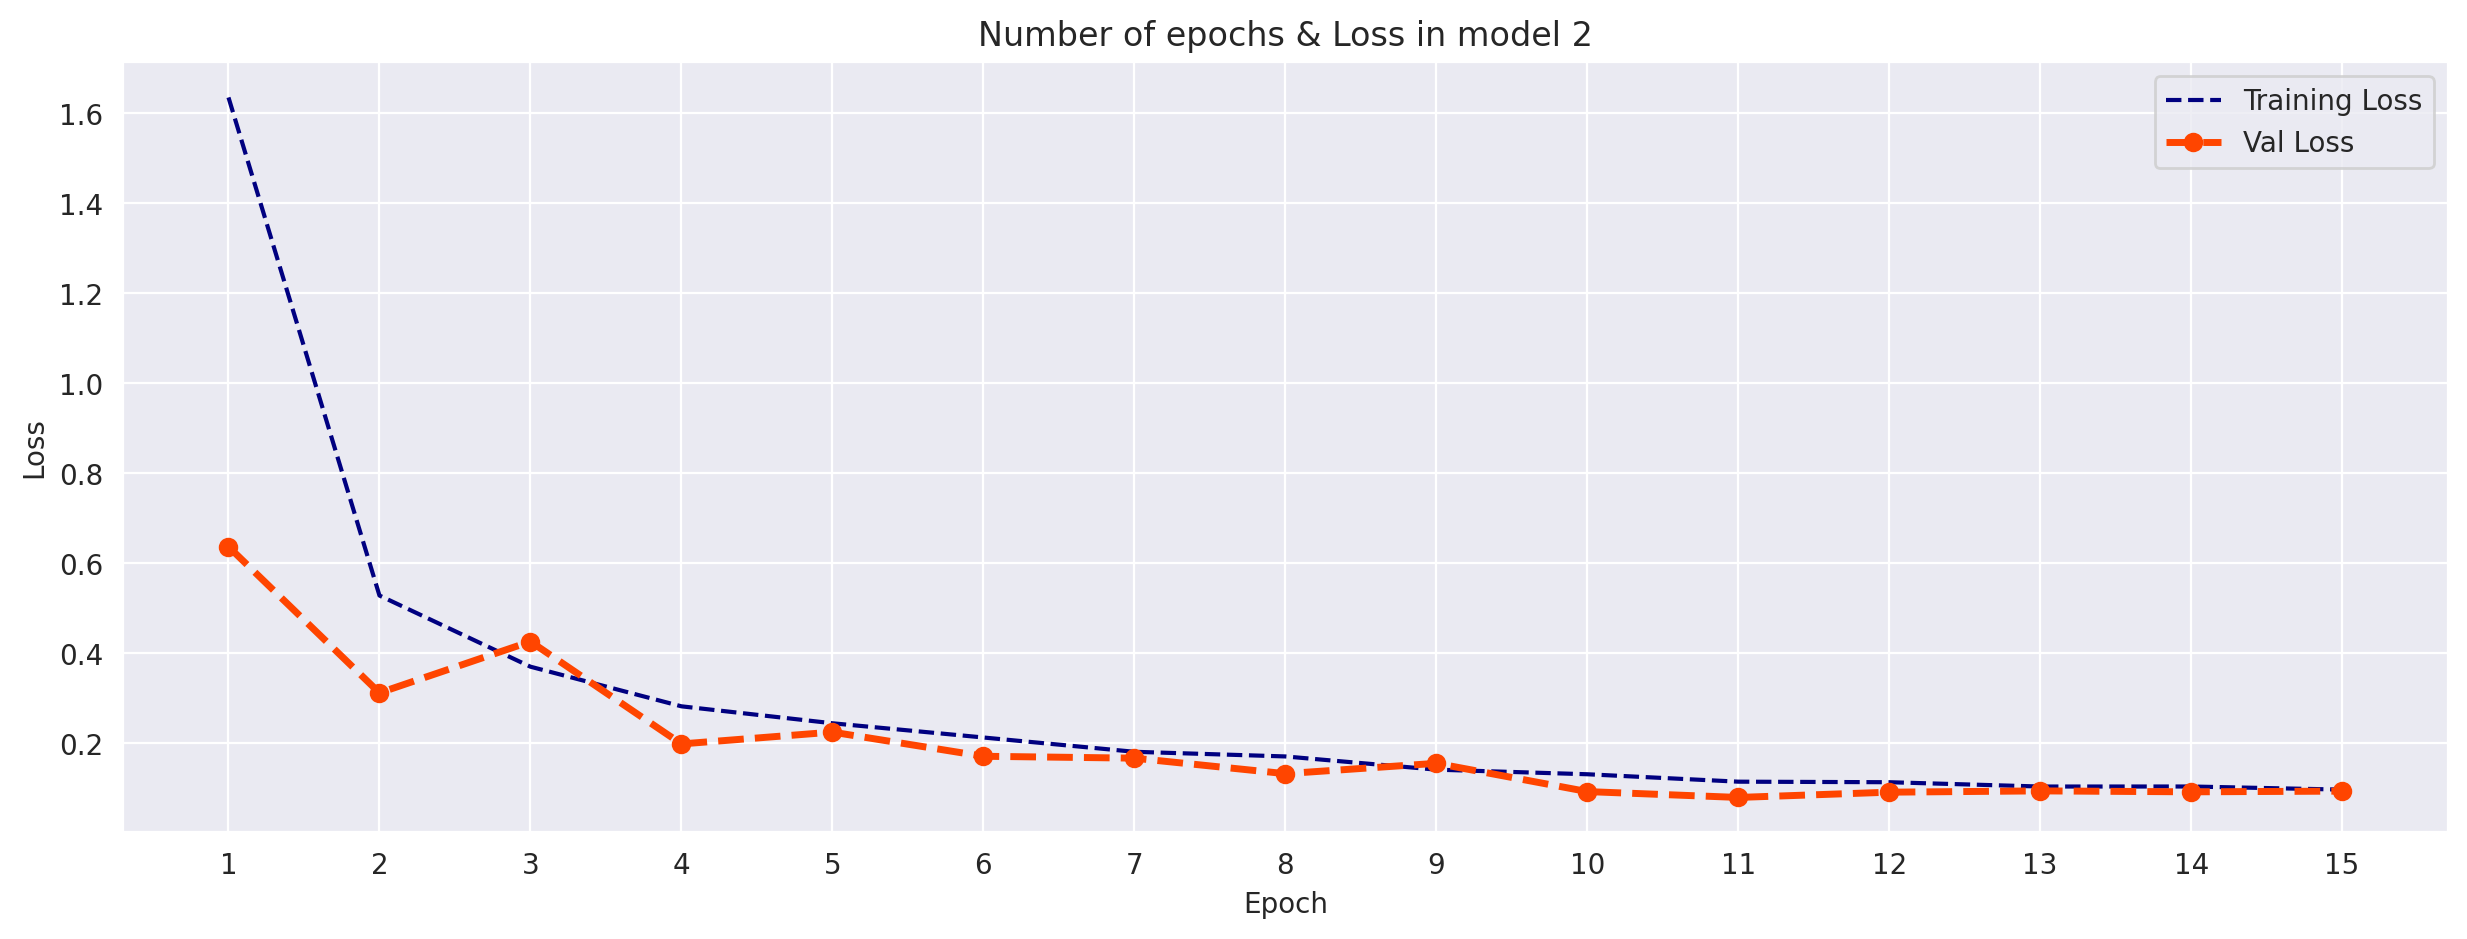

In [14]:
epoch_count = range(1, len(TL_model2) + 1)

# Visualize loss history
plt.figure(figsize=(15,5), dpi=200)
plt.plot(epoch_count, TL_model2, 'r--', color= 'navy')
plt.plot(epoch_count, VL_model2, '--bo',color= 'orangered', linewidth = '2.5', label='line with marker')
plt.legend(['Training Loss', 'Val Loss'])
plt.title('Number of epochs & Loss in model 2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(1,16,1))
plt.show();

**Overall Decreasing Loss**: Both the training and validation loss decrease significantly during the initial epochs, indicating that the model is learning effectively.

**Stabilization of Loss**: After around the 7th epoch, both training and validation loss reach a stable plateau, with minimal further improvement, suggesting that the model has almost converged.

**No Signs of Overfitting**: The training and validation loss curves remain close to each other throughout the epochs, indicating that the model generalizes well and does not overfit.

**Validation Loss Lower than Training Loss**: At certain points, the validation loss dips slightly below the training loss, which can occur due to regularization techniques (e.g., dropout) or early stopping that might favor better validation performanc

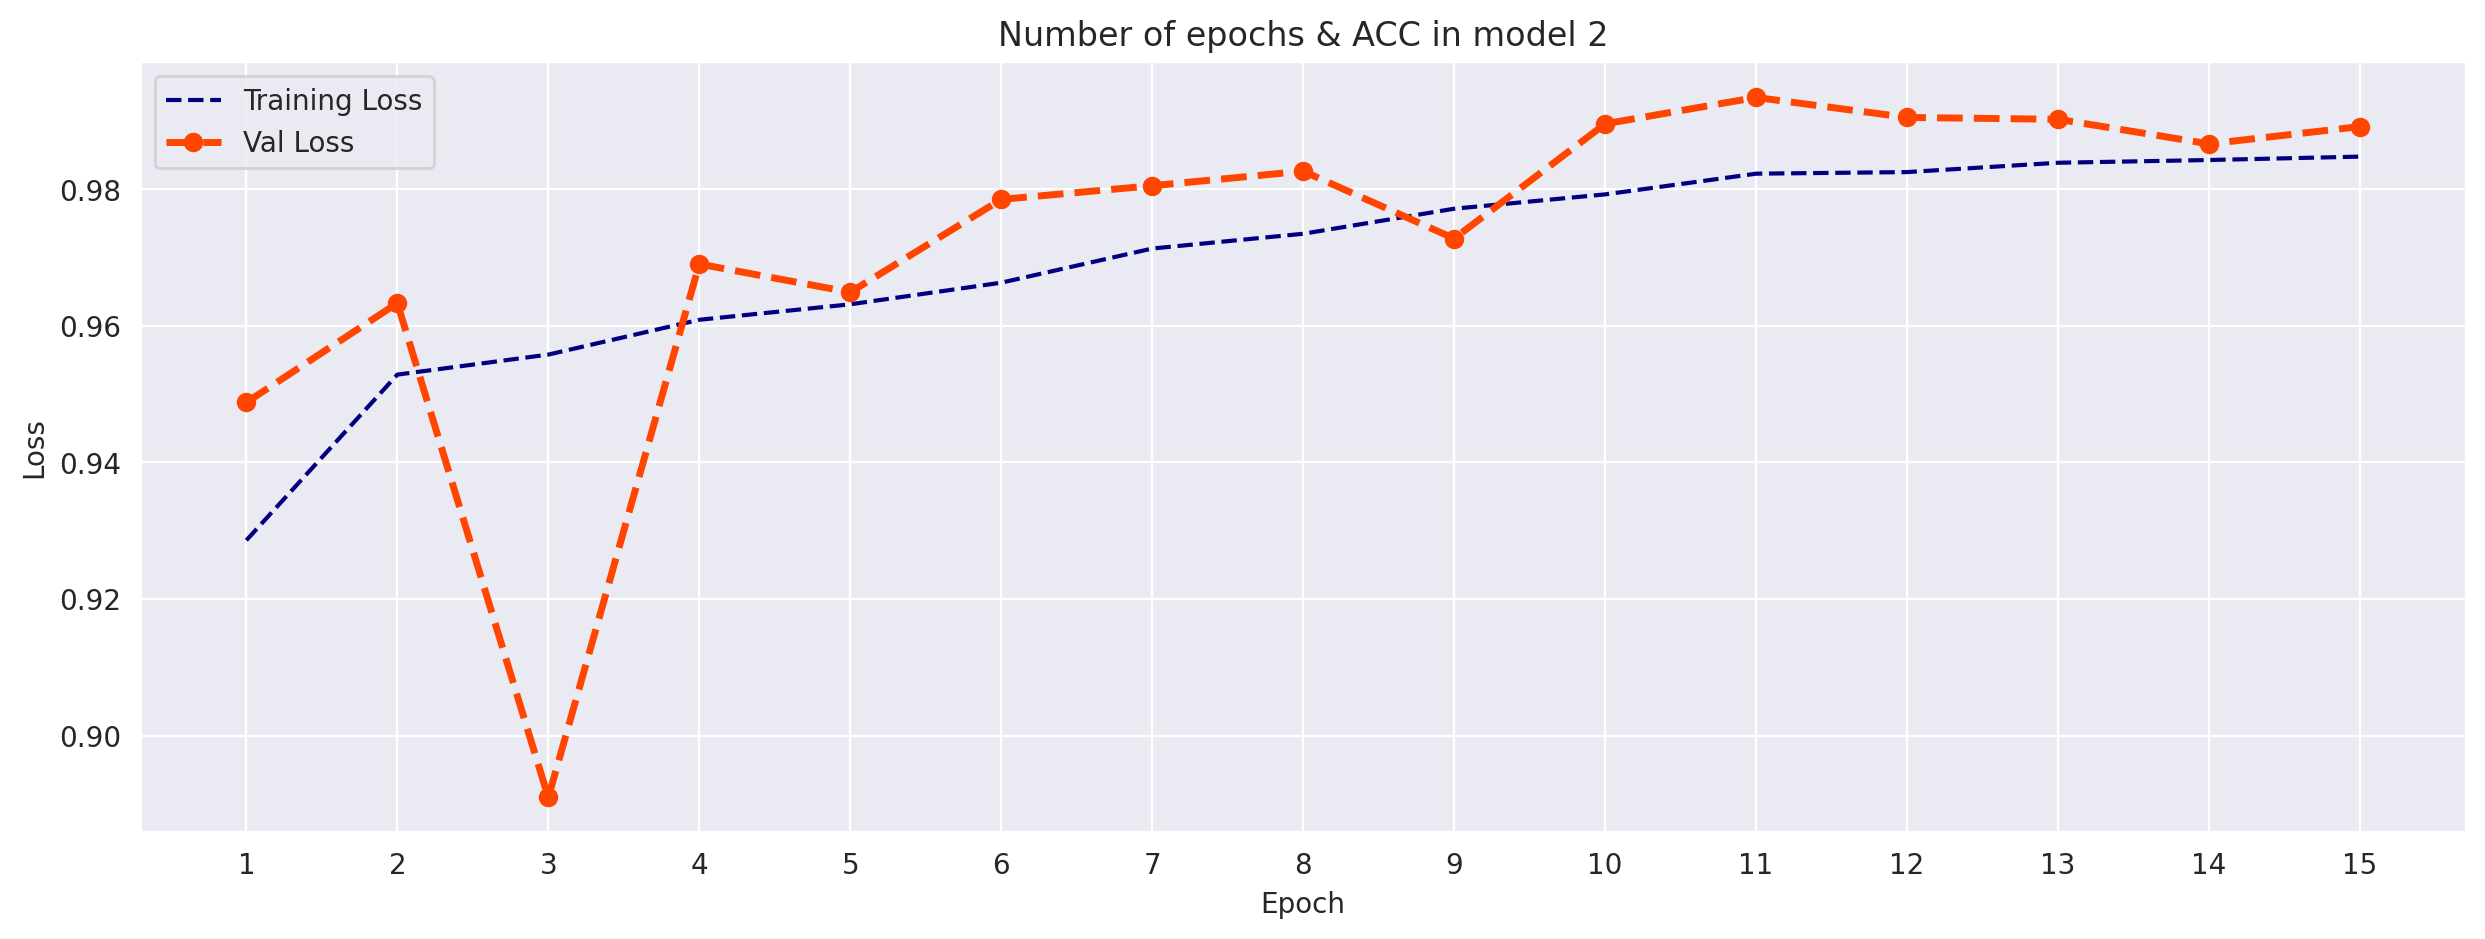

In [15]:
# Visualize Acc history
plt.figure(figsize=(15,5), dpi=200)
plt.plot(epoch_count, TA_model2, 'r--', color= 'navy')
plt.plot(epoch_count, VA_model2, '--bo',color= 'orangered', linewidth = '2.5', label='line with marker')
plt.legend(['Training Loss', 'Val Loss'])
plt.title('Number of epochs & ACC in model 2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(1,16,1))
plt.show();

In [7]:
with strategy.scope():
    # Create the model
    model3 = Sequential([
        # First Convolutional Block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.2),
    
        # Second Convolutional Block
        tf.keras.layers.Conv2D(64, (3, 3), activation='swish', kernel_regularizer = l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        # Third Convolutional Block
        tf.keras.layers.Conv2D(128, (3, 3), activation='swish', kernel_regularizer=l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    
    
        # Flatten the output
        tf.keras.layers.Flatten(),
    
        # Fully Connected Layers
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    # Define the checkpoint, explicitly setting the format to "h5"
    checkpoint = ModelCheckpoint(
    "best_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max"
)


# Compile the model
    model3.compile(optimizer=Adam(learning_rate=0.001),
               loss='categorical_crossentropy',
               metrics=['accuracy'])
    


In [8]:
model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,246,853 (84.87 MB)

 Trainable params: 22,246,405 (84.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Train the model
model3_history = model3.fit(
    train,
    epochs=20,
    validation_data=val,  
    callbacks = [checkpoint]

)

Epoch 1/20


2024-11-25 09:49:16.205020: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/cond/else/_166/cond/StatefulPartitionedCall/replica_1/sequential_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 427s 221ms/step - accuracy: 0.9020 - loss: 3.4083 - val_accuracy: 0.8840 - val_loss: 0.8375
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 213s 113ms/step - accuracy: 0.9575 - loss: 0.6102 - val_accuracy: 0.9216 - val_loss: 0.4961
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 212s 113ms/step - accuracy: 0.9656 - loss: 0.3864 - val_accuracy: 0.9488 - val_loss: 0.3494
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 210s 112ms/step - accuracy: 0.9690 - loss: 0.2527 - val_accuracy: 0.7873 - val_loss: 0.7984
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 211s 112ms/step - accuracy: 0.9686 - loss: 0.2228 - val_accuracy: 0.9787 - val_loss: 0.1574
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 211s 112ms/step - accuracy: 0.9720 - loss: 0.1879 - val_accuracy: 0.9793 - val_loss: 0.1498
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 214s 114ms/step - accuracy: 0.9751 - loss: 0.1613 - val_accuracy: 0.9828 - val_loss: 0.1343
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 211s 112ms/step - accuracy: 0.9

In [ ]:
TL_model3 = model3_history.history['loss']
VL_model3 = model3_history.history['val_loss']
TA_model3 = model3_history.history['accuracy']
VA_model3 = model3_history.history['val_accuracy']

In [ ]:
epoch_count = range(1, len(TL_model3) + 1)

# Visualize loss history
plt.figure(figsize=(15,5), dpi=200)
plt.plot(epoch_count, TL_model3, 'r--', color= 'navy')
plt.plot(epoch_count, VL_model3, '--bo',color= 'orangered', linewidth = '2.5', label='line with marker')
plt.legend(['Training Loss', 'Val Loss'])
plt.title('Number of epochs & Loss in model 3')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(1,16,1))
plt.show();

In [ ]:
epoch_count = range(1, len(TL_model3) + 1)

# Visualize loss history
plt.figure(figsize=(15,5), dpi=200)
plt.plot(epoch_count, TA_model3, 'r--', color= 'navy')
plt.plot(epoch_count, VA_model3, '--bo',color= 'orangered', linewidth = '2.5', label='line with marker')
plt.legend(['Training ACC', 'Val ACC'])
plt.title('Number of epochs & ACC in model 3')
plt.xlabel('Epoch')
plt.ylabel('ACC')
plt.xticks(np.arange(1,16,1))
plt.show();

In [11]:
with strategy.scope():
    # Create the model
    model4 = Sequential([
        # First Convolutional Block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.3),
    
        # Second Convolutional Block
        tf.keras.layers.Conv2D(64, (3, 3), activation='swish', kernel_regularizer = l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        # First Convolutional Block
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(224, 224, 3),kernel_regularizer = l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.2),
    
    
        # Flatten the output
        tf.keras.layers.Flatten(),
    
        # Fully Connected Layers
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    # Define the checkpoint, explicitly setting the format to "h5"
    checkpoint = ModelCheckpoint(
    "best_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max"
)

    test_callback = TestCallback(test)

# Compile the model
    model4.compile(optimizer=Adam(learning_rate=0.001),
               loss='categorical_crossentropy',
               metrics=['accuracy'])
    


In [12]:
model4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,246,853 (84.87 MB)

 Trainable params: 22,246,405 (84.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Train the model
model4_history = model4.fit(
    train,
    epochs=10,
    validation_data=val,  
    callbacks = [checkpoint, test_callback]

)

Epoch 1/10


2024-11-25 15:44:06.014650: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/cond/else/_168/cond/StatefulPartitionedCall/replica_1/sequential_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8984 - loss: 3.3667
 Epoch1: Test loss = 0.6070029735565186,Test Accuracy = 0.9415466785430908
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 654s 342ms/step - accuracy: 0.8985 - loss: 3.3658 - val_accuracy: 0.9415 - val_loss: 0.6050
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9633 - loss: 0.4896
 Epoch2: Test loss = 1.013582468032837,Test Accuracy = 0.9481066465377808
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 337s 179ms/step - accuracy: 0.9633 - loss: 0.4896 - val_accuracy: 0.9563 - val_loss: 0.9703
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9625 - loss: 0.4858
 Epoch3: Test loss = 0.3459653854370117,Test Accuracy = 0.9838933348655701
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 322s 171ms/step - accuracy: 0.9625 - loss: 0.4858 - val_accuracy: 0.9873 - val_loss: 0.3333
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9735 - loss: 0.2802
 Epoch4: Test loss = 0.24948489665985107,Test Accuracy = 0.98

In [14]:
TL_model4 = model4_history.history['loss']
VL_model4 = model4_history.history['val_loss']
TA_model4 = model4_history.history['accuracy']
VA_model4 = model4_history.history['val_accuracy']

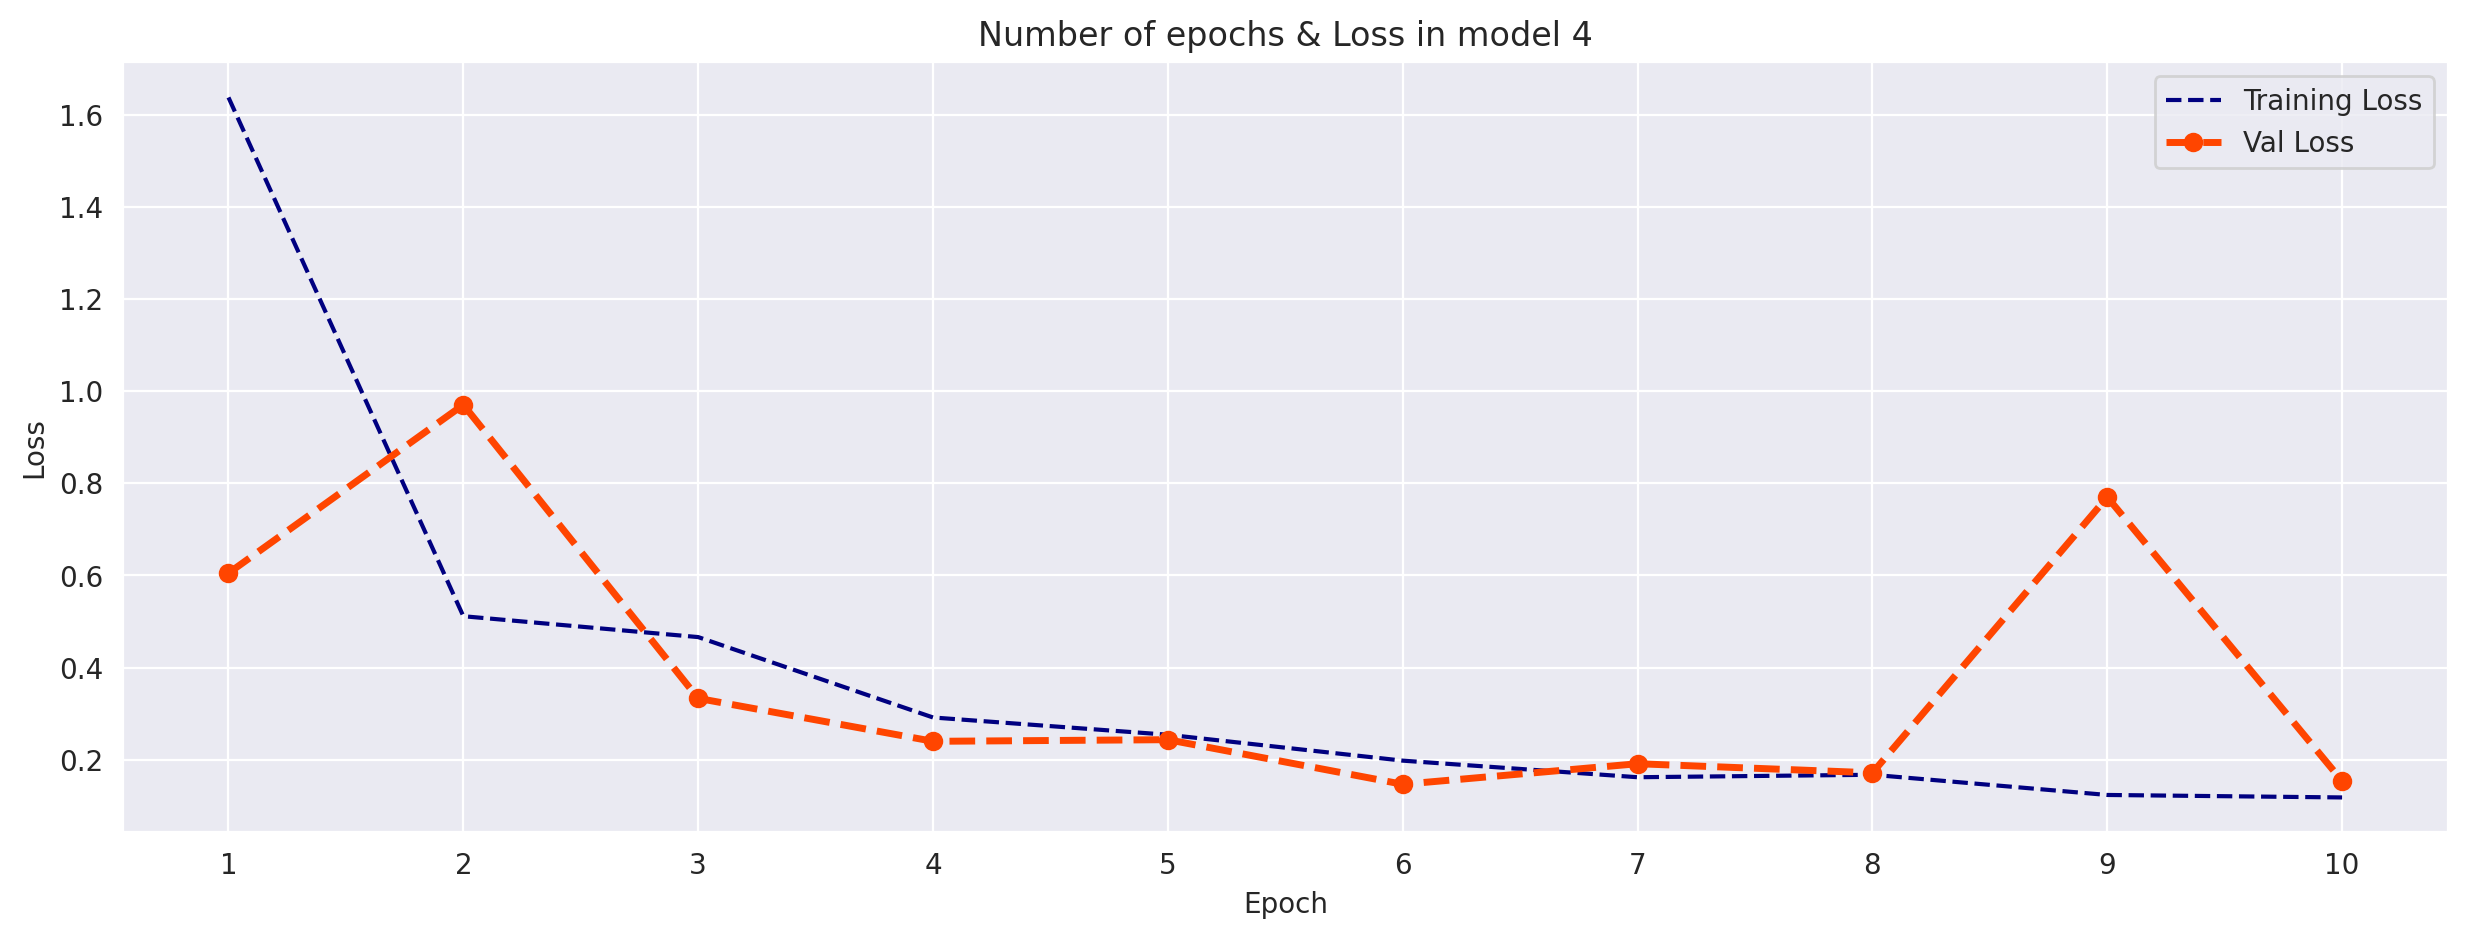

In [16]:
epoch_count = range(1, len(TL_model4) + 1)

# Visualize loss history
plt.figure(figsize=(15,5), dpi=200)
plt.plot(epoch_count, TL_model4, 'r--', color= 'navy')
plt.plot(epoch_count, VL_model4, '--bo',color= 'orangered', linewidth = '2.5', label='line with marker')
plt.legend(['Training Loss', 'Val Loss'])
plt.title('Number of epochs & Loss in model 4')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(1,11,1))
plt.show();

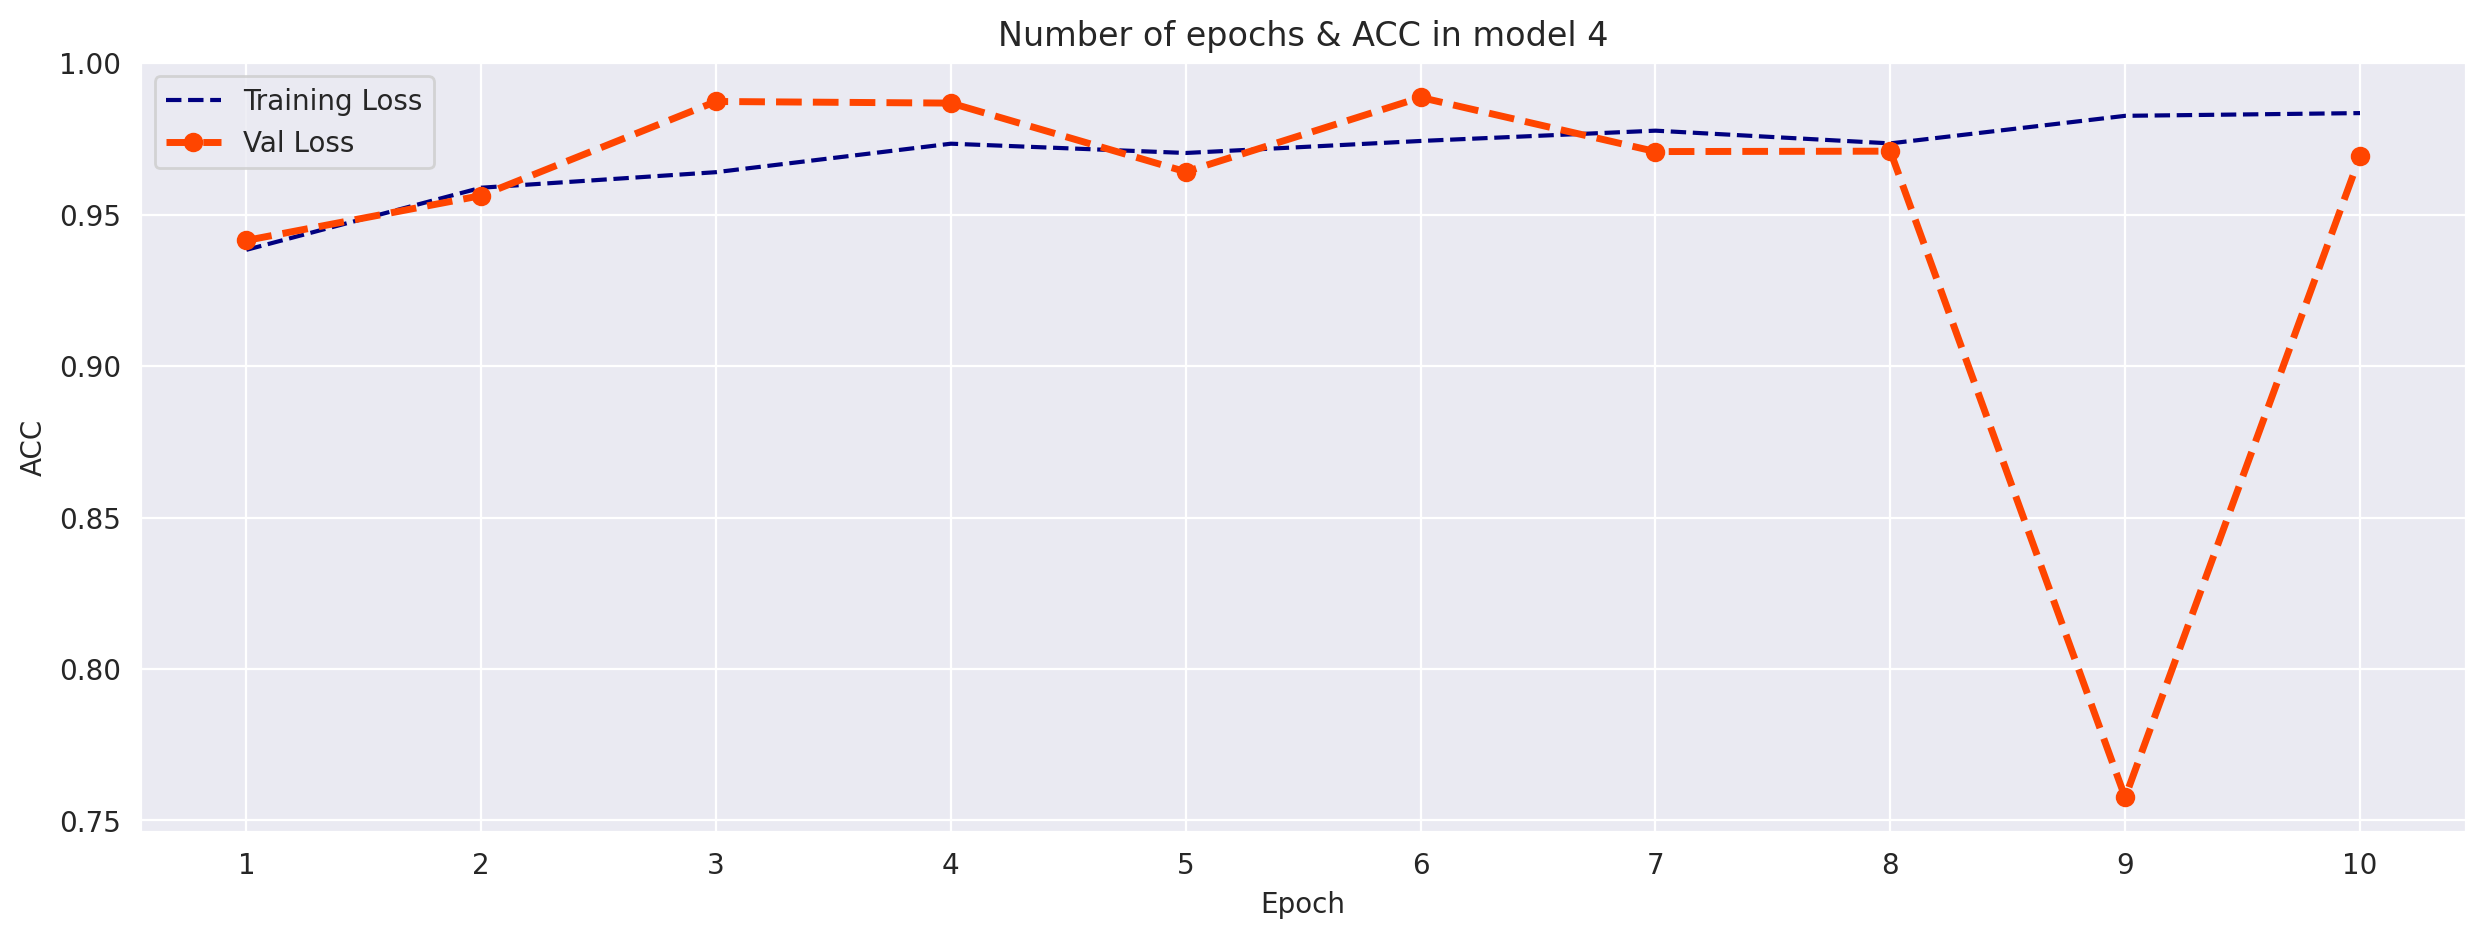

In [17]:
epoch_count = range(1, len(TL_model4) + 1)

# Visualize loss history
plt.figure(figsize=(15,5), dpi=200)
plt.plot(epoch_count, TA_model4, 'r--', color= 'navy')
plt.plot(epoch_count, VA_model4, '--bo',color= 'orangered', linewidth = '2.5', label='line with marker')
plt.legend(['Training Loss', 'Val Loss'])
plt.title('Number of epochs & ACC in model 4')
plt.xlabel('Epoch')
plt.ylabel('ACC')
plt.xticks(np.arange(1,11,1))
plt.show();